# PyTorch

Alttaki kodda kaggledan veri setimizi alıp gelen zip dosyası içindekileri dışarı çıkartıp zip dosyasını siliyorum.

In [18]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies
from zipfile import ZipFile
import os
for i in os.listdir('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/SatelliteWaterBodies'):
    if '.zip' in i:
        print(i)
        with ZipFile(i, 'r') as zipObj:
            zipObj.extractall()
        os.remove(i)


  0%|          | 0.00/247M [00:00<?, ?B/s]
  0%|          | 1.00M/247M [00:00<00:39, 6.57MB/s]
  2%|▏         | 4.00M/247M [00:00<00:15, 16.6MB/s]
  3%|▎         | 7.00M/247M [00:00<00:12, 20.7MB/s]
  4%|▍         | 10.0M/247M [00:00<00:10, 22.8MB/s]
  5%|▌         | 13.0M/247M [00:00<00:10, 24.0MB/s]
  6%|▋         | 16.0M/247M [00:00<00:09, 24.7MB/s]
  8%|▊         | 19.0M/247M [00:00<00:09, 25.1MB/s]
  9%|▉         | 22.0M/247M [00:01<00:09, 25.3MB/s]
 10%|█         | 25.0M/247M [00:01<00:09, 25.4MB/s]
 11%|█▏        | 28.0M/247M [00:01<00:08, 25.5MB/s]
 13%|█▎        | 31.0M/247M [00:01<00:08, 25.6MB/s]
 14%|█▍        | 34.0M/247M [00:01<00:08, 25.6MB/s]
 15%|█▍        | 37.0M/247M [00:01<00:08, 25.7MB/s]
 16%|█▌        | 40.0M/247M [00:01<00:08, 25.7MB/s]
 17%|█▋        | 43.0M/247M [00:01<00:08, 25.6MB/s]
 19%|█▊        | 46.0M/247M [00:01<00:08, 25.5MB/s]
 20%|█▉        | 49.0M/247M [00:02<00:08, 25.3MB/s]
 21%|██        | 52.0M/247M [00:02<00:08, 25.2MB/s]
 22%|██▏       | 55.


satellite-images-of-water-bodies.zip


Gerekebilecek yüklemeler aşağıdadır.

Torch'u daha önce yüklemediyseniz sitesinden kendinize göre ayarlarla yükleyebilirsiniz...

In [1]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch 
#!pip install -U git+https://github.com/albumentations-team/albumentations

Gerekli yüklemelerimizi yapıyoruz. 

Fotoğraf boyutunu 256'ya 256 olarak belirliyoruz...

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

size = (256, 256)

import torch

torch.cuda.is_available()

True

Veriyi düzgün hata vermeyecek şekilde modelimize göndermeden önce düzenlememiz ve modelimize uygun bir şekle getirmemiz gerekiyor.

Bunun için kendimize bir sınıf oluşturup içine olmasını istediğimiz fonksiyonları yazıyoruz.


In [20]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = self.transform(mask)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

Verimizi glob ile X-Y olarak yüklüyoruz.

In [21]:
X = sorted(glob.glob('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/SatelliteWaterBodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/SatelliteWaterBodies/Water Bodies Dataset/Masks/*'))

Yüklediğimiz verinin varlığını kontrol etmemiz gerekiyor. Burada yanlış bir yol girildiğinde alttaki sonucumuz 0 çıkacaktır.

In [22]:
len(X)

2841

Verimizi train ve validation için bölüyoruz ve üstteki sınıfımızla beraber şekillendiriyoruz.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

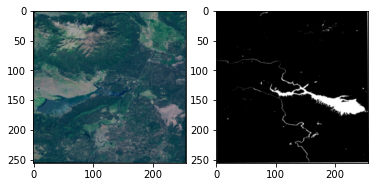

In [25]:
img, mask = train_dataset[0]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


In [26]:
img.shape

torch.Size([3, 256, 256])

Diğer torch'ta olmayan kısımlara gelmeye başladık. Burada diğerinde belirlediğimiz weights ve encoder-decoder kullanılmadığı için burada mimariyi elle yazmamız gerekiyor...

Bunu yapmanın bir güzel yanı da istenilen şekilde şekillendirilmeye sahip olmasıdır. İstenildiği gibi layerlar değiştirilebilir ve ayarlanabilir...

In [27]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
    
    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [28]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [29]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x

Burada kafa karıştıran bölüm fonksiyonlar arasında bağlantı olmamasına rağmen fonksiyonların bağlı olması olabilir. Bunu sağlayanın class'ın başlangıcında yazdığımız nn.Module'dür. 

nn.Module forward fonksiyonunu __init__ ile bağlayıp bir mimarı oluşturuyor...

In [30]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)
        
        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)

        return output_mask  

İstediğimiz ayarları yazabiliriz ve denemelerini yapabiliriz.

In [32]:
batch_size = 32
num_epochs = 50
lr = 1e-3
checkpoint_path = "./checkpoint.pth"

DataLoader kullanılarak modele girdileri hazırlanıyoruz.

In [33]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

Modelimizi derliyoruz ve 'cuda' ile çalışmasını sağlıyoruz.

In [34]:
device = 'cuda'
model = UNet()
model = model.to(device)

Kayıp fonksiyonumuzu kendimiz yazıyoruz...

In [35]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

Eğitim döngüsünde işler daha basite indirgensin diye eğitim ve eval için kullanılacak fonksiyonu şimdiden yazıyoruz.

Kayıplarımızı belirlemek için değeri ilk başta sıfırlıyoruz. Daha sonra fotoğrafları gradiyent olmadan sokup kayıpımızı hesaplıyoruz...

In [37]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in tqdm(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
#         x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

Burada ise eğitim kısmına benzer bir kayıp hesabı yapıyoruz fakat buradaki önemli işlerden birisi kaybımızı direkt ele alıyor oluşumuz ve no_grad'ın izlenmesidir.

In [38]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

Adam optimizörünü kullanıyoruz ve eğitim döngümüzü kuruyoruz. 

Burada en iyi modeli kaydetmek ve kaybımızı her adımda görmek istiyoruz...

In [ ]:
train = []
valid = []

best_valid_loss = float("inf")

for epoch in range(50):
        train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train.append(train_loss)
        valid.append(valid_loss)        
        
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        data_str = f'Epoch: {epoch+1:02}\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

In [ ]:
model.load_state_dict(torch.load('./checkpoint.pth'))

image,mask=valid_dataset[20]

logits_mask=model(image.to(device, dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > 0.1)*1.0

In [ ]:
f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))